In [7]:
import pandas as pd
import matplotlib.pyplot as plt

score_bucket
low       34344
medium    17172
high      17172
Name: count, dtype: int64
Bucket thresholds for log_score_cap:
0.50    0.693147
0.75    1.098612
1.00    2.484907
Name: log_score_cap, dtype: float64


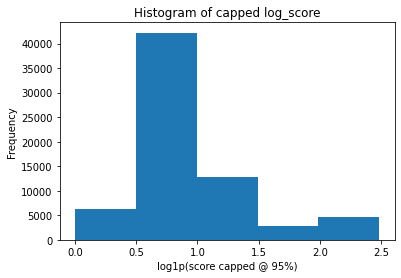

In [96]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv("./updated_data_rp3/data/careeradvice/combined_careeradvice_raw.csv", low_memory=False)
df["score"] = pd.to_numeric(df["score"], errors="coerce")
df["num_comments"] = pd.to_numeric(df.get("num_comments", np.nan), errors="coerce")
df = df.dropna(subset=["score","title","text"]).reset_index(drop=True)


# --- cap the right tail; don't drop rows for final df ---
q95 = df["score"].quantile(0.95)
df["log_score_cap"] = np.log1p(df["score"].clip(upper=q95))

# percentile rank on capped variable; 'first' prevents ties collapsing medium
df["log_score_pct"] = df["log_score_cap"].rank(method="first", pct=True)

# buckets: 0–50, 50–75, 75–100
df["score_bucket"] = pd.cut(
    df["log_score_pct"],
    bins=[0, 0.50, 0.75, 1.0],
    labels=["low","medium","high"],
    include_lowest=True, right=True
)

print(df["score_bucket"].value_counts().reindex(["low","medium","high"]))
thresholds = df["log_score_cap"].quantile([0.5, 0.75, 1.0])
print("Bucket thresholds for log_score_cap:")
print(thresholds)

plt.hist(df["log_score_cap"], bins=5)
plt.title("Histogram of capped log_score")
plt.xlabel("log1p(score capped @ 95%)")
plt.ylabel("Frequency")
plt.show()

In [123]:
# PUT BUCKET CATEGORY INTO NEW COLUMN
# CLEAN THE DATA -- very briefly

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s?!.,:;']", " ", text)
    return re.sub(r"\s+", " ", text).strip()

original_df = pd.read_csv("./updated_data_rp3/data/careeradvice/combined_careeradvice_raw.csv", low_memory=False)
clean_df = original_df.copy()

clean_df["title"] = clean_df["title"].apply(clean_text)
clean_df["text"] = clean_df["text"].apply(clean_text)
clean_df = clean_df[(clean_df["title"] != "") & (clean_df["text"] != "")].reset_index(drop=True)


# low_bucket = thresholds.iloc[0]
# medium_bucket = thresholds.iloc[1]
# high_bucket = thresholds.iloc[2]

clean_df["log_score"] = np.log1p(clean_df["score"])

clean_df["bucket_category"] = pd.qcut(
    clean_df["log_score"],
    q=[0.0, 0.50, 0.75, 1.0],
    labels=["low","medium","high"]
)
print(clean_df["bucket_category"].value_counts(normalize=True))



bucket_category
low       0.704315
high      0.159338
medium    0.136346
Name: proportion, dtype: float64


In [127]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    clean_df,
    test_size=0.2,
    stratify=clean_df["bucket_category"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["bucket_category"],
    random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Optional sanity check
print("\nTrain distribution:\n", train_df["bucket_category"].value_counts(normalize=True))
print("\nVal distribution:\n", val_df["bucket_category"].value_counts(normalize=True))
print("\nTest distribution:\n", test_df["bucket_category"].value_counts(normalize=True))


Train: 43868 | Val: 10968 | Test: 13710

Train distribution:
 bucket_category
low       0.704317
high      0.159319
medium    0.136364
Name: proportion, dtype: float64

Val distribution:
 bucket_category
low       0.704322
high      0.159373
medium    0.136306
Name: proportion, dtype: float64

Test distribution:
 bucket_category
low       0.704303
high      0.159373
medium    0.136324
Name: proportion, dtype: float64


In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# --- Prep target + text ---
df = clean_df.dropna(subset=["bucket_category"]).copy()
df["bucket_category"] = df["bucket_category"].astype(str)

# use title + text as the signal (or switch to just text if you prefer)
df["text_all"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()

# --- Stratified splits ---
X_train, X_test, y_train, y_test = train_test_split(
    df["text_all"], df["bucket_category"],
    test_size=0.2, stratify=df["bucket_category"], random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2, stratify=y_train, random_state=42
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
print("\nTrain distribution:\n", y_train.value_counts(normalize=True))
print("\nVal distribution:\n", y_val.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))

# --- Text-only pipeline ---
clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1, 2),   # unigrams + bigrams often help
        min_df=5,             # ignore very rare terms
        max_df=0.9,           # ignore extremely common terms
        max_features=200_000  # cap vocab size to control memory
    )),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",  # handle class imbalance
        multi_class="ovr",
        solver="liblinear"        # solid for sparse, OVR setup
    )),
])

# --- Train ---
clf.fit(X_train, y_train)

# --- Validate ---
print("\nValidation performance:")
y_val_pred = clf.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=3))

# --- Test ---
print("\nTest performance:")
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=3))

print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred, labels=sorted(y_test.unique())))


Train: 43868 | Val: 10968 | Test: 13710

Train distribution:
 bucket_category
low       0.704317
high      0.159319
medium    0.136364
Name: proportion, dtype: float64

Val distribution:
 bucket_category
low       0.704322
high      0.159373
medium    0.136306
Name: proportion, dtype: float64

Test distribution:
 bucket_category
low       0.704303
high      0.159373
medium    0.136324
Name: proportion, dtype: float64

Validation performance:
              precision    recall  f1-score   support

        high      0.380     0.344     0.361      1748
         low      0.743     0.876     0.804      7725
      medium      0.179     0.033     0.056      1495

    accuracy                          0.676     10968
   macro avg      0.434     0.418     0.407     10968
weighted avg      0.608     0.676     0.631     10968


Test performance:
              precision    recall  f1-score   support

        high      0.357     0.326     0.341      2185
         low      0.741     0.874     0.802  

In [130]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

df = clean_df.dropna(subset=["bucket_category"]).copy()
df["y"] = df["bucket_category"].astype(str)
df["text_all"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()

X_train, X_test, y_train, y_test = train_test_split(
    df["text_all"], df["y"], test_size=0.2, stratify=df["y"], random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        sublinear_tf=True,     # <-- big win for long-tail terms
        ngram_range=(1,2)
    )),
    ("clf", LinearSVC(class_weight="balanced"))  # stronger than LR on text
])

param_grid = {
    "tfidf__min_df": [3, 5, 10],
    "tfidf__max_df": [0.85, 0.9, 0.95],
    "tfidf__ngram_range": [(1,2), (1,3)],
    "clf__C": [0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_

print("\nValidation:")
print(classification_report(y_val, best.predict(X_val), digits=3))

print("\nTest:")
print(classification_report(y_test, best.predict(X_test), digits=3))


/Users/emilyho/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/emilyho/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/emilyho/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/emilyho/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/emi

Best params: {'clf__C': 0.5, 'tfidf__max_df': 0.9, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 2)}

Validation:
              precision    recall  f1-score   support

        high      0.344     0.321     0.332      1748
         low      0.742     0.820     0.779      7725
      medium      0.164     0.088     0.115      1495

    accuracy                          0.641     10968
   macro avg      0.417     0.410     0.409     10968
weighted avg      0.600     0.641     0.617     10968


Test:
              precision    recall  f1-score   support

        high      0.328     0.317     0.323      2185
         low      0.744     0.819     0.779      9656
      medium      0.173     0.090     0.118      1869

    accuracy                          0.639     13710
   macro avg      0.415     0.409     0.407     13710
weighted avg      0.600     0.639     0.616     13710



original(68692, 13)
(62412, 13)
Skew (raw score):    89.53783383866588


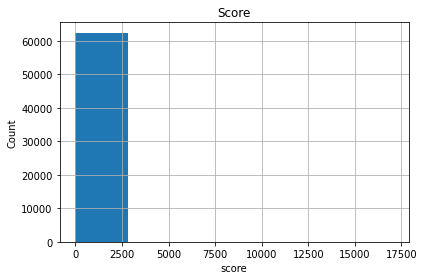

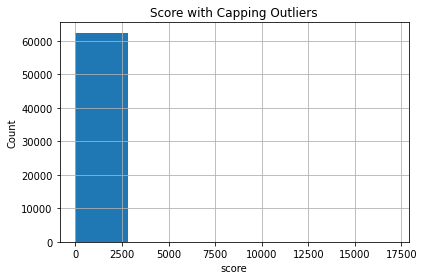

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import skew

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s?!.,:;']", " ", text)
    return re.sub(r"\s+", " ", text).strip()

file_path = "./updated_data_rp3/data/careeradvice/combined_careeradvice_raw.csv"
df = pd.read_csv(file_path, low_memory=False)

print("original" + str(df.shape))
df["title"] = df["title"].apply(clean_text)
df["text"] = df["text"].apply(clean_text)
df = df[df["text"] != ""]
df = df[(df["score"] != 0) & (df["num_comments"] != 0)]

print(df.shape)

df["score"].hist(bins=6)
plt.title("Score")
plt.xlabel("score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd, numpy as np, re
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# ---------- load & clean ----------
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+|https\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s?!.,:;']", " ", t)
    return re.sub(r"\s+", " ", t).strip()

df = pd.read_csv("./updated_data_rp3/data/careeradvice/combined_careeradvice_raw.csv", low_memory=False)

for c in ["score","num_comments"]:
    df[c] = pd.to_numeric(df.get(c, np.nan), errors="coerce")

df["title"] = df.get("title","").apply(clean_text)
df["text"]  = df.get("text","").apply(clean_text)
df = df[(df["title"]!="") | (df["text"]!="")].dropna(subset=["score"]).reset_index(drop=True)
df["num_comments"] = df["num_comments"].fillna(0)

# ---------- label: desirability (top 20% within month if possible) ----------
def parse_ts(s):
    x = pd.to_datetime(s, utc=True, errors="coerce")
    if x.notna().all(): return x
    num = pd.to_numeric(s, errors="coerce")
    return pd.to_datetime(num, unit="s", utc=True, errors="coerce")

if "created_utc" in df.columns:
    ts = parse_ts(df["created_utc"])
    df["ym"] = ts.dt.to_period("M").astype(str).fillna("ALL")
else:
    df["ym"] = "ALL"

df["engagement_log"] = np.log1p(df["score"] + 0.5*df["num_comments"])
df["pct"] = df.groupby("ym")["engagement_log"].rank(pct=True, method="average")
df["desirable"] = (df["pct"] >= 0.80).astype(int)

# ---------- features ----------
def combine_text(X):
    return (X["title"].fillna("") + " " + X["text"].fillna("")).values

def ling_feats(X):
    s = (X["title"].fillna("") + " " + X["text"].fillna(""))
    n_chars = s.str.len()
    n_words = s.str.split().apply(len).astype(float)
    avg_word_len = np.where(n_words>0, n_chars/n_words, 0)
    exclam = s.str.count("!")
    qmark = s.str.count(r"\?")
    firstp = s.str.count(r"\b(i|me|my|mine|we|us|our|ours)\b")
    secondp= s.str.count(r"\b(you|your|yours|u)\b")
    numer  = s.str.count(r"\b\d+(\.\d+)?\b")
    return np.vstack([n_chars, n_words, avg_word_len, exclam, qmark, firstp, secondp, numer]).T

txt_block = Pipeline([
    ("join", FunctionTransformer(combine_text, validate=False)),
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95, max_features=50_000))
])

ling_block = Pipeline([
    ("fe", FunctionTransformer(ling_feats, validate=False)),
    ("sc", StandardScaler(with_mean=False))
])

feats = ColumnTransformer([
    ("txt",  txt_block, ["title","text"]),
    ("ling", ling_block, ["title","text"]),
], sparse_threshold=0.3)

model = LogisticRegression(max_iter=300, class_weight="balanced")

pipe = Pipeline([("feats", feats), ("clf", model)])

# ---------- split (time-aware if possible) ----------
groups = df["ym"].astype(str)
if groups.nunique() > 1:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(df, df["desirable"], groups=groups))
    train, test = df.iloc[tr_idx], df.iloc[te_idx]
else:
    train, test = train_test_split(df, test_size=0.2, stratify=df["desirable"], random_state=42)

X_train = train[["title","text"]]
y_train = train["desirable"].astype(int).values
X_test  = test[["title","text"]]
y_test  = test["desirable"].astype(int).values

# ---------- train & evaluate ----------
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:,1]
preds = (probs >= 0.5).astype(int)

print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))
print("PR  AUC:", round(average_precision_score(y_test, probs), 3))
print(classification_report(y_test, preds, digits=3))

# ---------- (optional) inspect most influential terms ----------
# Uncomment to see top/bottom TF-IDF terms by weight
# clf = pipe.named_steps["clf"]
# tfidf = pipe.named_steps["feats"].named_transformers_["txt"].named_steps["tfidf"]
# vocab = np.array(tfidf.get_feature_names_out())
# coefs = clf.coef_[0][:len(vocab)]
# print("Top + terms:", vocab[np.argsort(coefs)][-20:][::-1])
# print("Top - terms:", vocab[np.argsort(coefs)][:20])


/var/folders/pc/4kh3334956x9gt9qq4g7n9mh0000gn/T/ipykernel_7699/2935761190.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x = pd.to_datetime(s, utc=True, errors="coerce")
/var/folders/pc/4kh3334956x9gt9qq4g7n9mh0000gn/T/ipykernel_7699/2935761190.py:36: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["ym"] = ts.dt.to_period("M").astype(str).fillna("ALL")
/Users/emilyho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

ROC AUC: 0.769
PR  AUC: 0.435
              precision    recall  f1-score   support

           0      0.901     0.723     0.802     13511
           1      0.376     0.677     0.484      3336

    accuracy                          0.714     16847
   macro avg      0.639     0.700     0.643     16847
weighted avg      0.797     0.714     0.739     16847



In [10]:
import pandas as pd, numpy as np, re
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import (
    r2_score, mean_squared_error,
    roc_auc_score, average_precision_score, classification_report
)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

# =========================
# 0) Load & clean
# =========================
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+|https\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s?!.,:;']", " ", t)
    return re.sub(r"\s+", " ", t).strip()

df = pd.read_csv("./updated_data_rp3/data/careeradvice/combined_careeradvice_raw.csv", low_memory=False)

for c in ["score","num_comments"]:
    df[c] = pd.to_numeric(df.get(c, np.nan), errors="coerce")

df["title"] = df.get("title","").apply(clean_text)
df["text"]  = df.get("text","").apply(clean_text)
df = df[(df["title"]!="") | (df["text"]!="")].dropna(subset=["score","num_comments"]).reset_index(drop=True)

# =========================
# 1) Time key (for leakage-safe splits & per-month percentiles)
# =========================
def parse_ts(s):
    # robustly parse created_utc if present; supports ISO or epoch seconds
    x = pd.to_datetime(s, utc=True, errors="coerce")
    if x.notna().all():
        return x
    # fall back to epoch seconds
    num = pd.to_numeric(s, errors="coerce")
    return pd.to_datetime(num, unit="s", utc=True, errors="coerce")

if "created_utc" in df.columns:
    ts = parse_ts(df["created_utc"])
    df["ym"] = ts.dt.to_period("M").astype(str).fillna("ALL")
else:
    df["ym"] = "ALL"

# =========================
# 2) Feature pipeline (shared)
# =========================
def combine_text(X):
    return (X["title"].fillna("") + " " + X["text"].fillna("")).values

def ling_feats(X):
    s = (X["title"].fillna("") + " " + X["text"].fillna(""))
    n_chars = s.str.len()
    n_words = s.str.split().apply(len).astype(float)
    avg_word_len = np.where(n_words>0, n_chars/n_words, 0)
    exclam = s.str.count("!")
    qmark = s.str.count(r"\?")
    firstp = s.str.count(r"\b(i|me|my|mine|we|us|our|ours)\b")
    secondp= s.str.count(r"\b(you|your|yours|u)\b")
    numer  = s.str.count(r"\b\d+(\.\d+)?\b")
    return np.vstack([n_chars, n_words, avg_word_len, exclam, qmark, firstp, secondp, numer]).T

txt_block = Pipeline([
    ("join", FunctionTransformer(combine_text, validate=False)),
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95, max_features=50_000))
])

ling_block = Pipeline([
    ("fe", FunctionTransformer(ling_feats, validate=False)),
    ("sc", StandardScaler(with_mean=False))
])

feats = ColumnTransformer([
    ("txt",  txt_block, ["title","text"]),
    ("ling", ling_block, ["title","text"]),
], sparse_threshold=0.3)

# =========================
# 3) Targets
#    - Regressions on log1p(score) and log1p(num_comments)
#    - Binary labels for extremes (per month): top 10% (high) and bottom 10% (low)
# =========================
df["score_log"] = np.log1p(df["score"].clip(lower=0))
df["comments_log"] = np.log1p(df["num_comments"].clip(lower=0))

hi_q, lo_q = 0.90, 0.10  # "very well" / "very poorly" within month

def per_group_flags(s, group, hi=0.90, lo=0.10):
    q_hi = s.groupby(group).transform(lambda g: g.quantile(hi))
    q_lo = s.groupby(group).transform(lambda g: g.quantile(lo))
    return (s >= q_hi).astype(int), (s <= q_lo).astype(int)

high_score, low_score = per_group_flags(df["score"], df["ym"], hi_q, lo_q)
high_comm,  low_comm  = per_group_flags(df["num_comments"], df["ym"], hi_q, lo_q)

df["high_score"] = high_score
df["low_score"]  = low_score
df["high_comm"]  = high_comm
df["low_comm"]   = low_comm

# =========================
# 4) Train/test split (time-aware if multiple months)
# =========================
groups = df["ym"].astype(str)
if groups.nunique() > 1:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(df, None, groups=groups))
    train, test = df.iloc[tr_idx], df.iloc[te_idx]
else:
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[["high_score","high_comm"]])

X_train = train[["title","text"]]
X_test  = test[["title","text"]]

# =========================
# 5) Models  (sparse-friendly)
# =========================
# Regressors (continuous, sparse OK)
reg_score = Pipeline([
    ("feats", feats),
    ("reg", Ridge(alpha=1.0, random_state=42))
])

reg_comm = Pipeline([
    ("feats", feats),
    ("reg", Ridge(alpha=1.0, random_state=42))
])

# Classifiers (extremes, sparse OK)
clf_hi_score = Pipeline([
    ("feats", feats),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
clf_lo_score = Pipeline([
    ("feats", feats),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
clf_hi_comm = Pipeline([
    ("feats", feats),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
clf_lo_comm = Pipeline([
    ("feats", feats),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])

# =========================
# 6) Fit
# =========================
# Regressions
y_score_log_tr = train["score_log"]
y_comm_log_tr  = train["comments_log"]

reg_score.fit(X_train, y_score_log_tr)
reg_comm.fit(X_train,  y_comm_log_tr)

# Classifiers
y_hi_score_tr = train["high_score"].astype(int)
y_lo_score_tr = train["low_score"].astype(int)
y_hi_comm_tr  = train["high_comm"].astype(int)
y_lo_comm_tr  = train["low_comm"].astype(int)

clf_hi_score.fit(X_train, y_hi_score_tr)
clf_lo_score.fit(X_train, y_lo_score_tr)
clf_hi_comm.fit(X_train,  y_hi_comm_tr)
clf_lo_comm.fit(X_train,  y_lo_comm_tr)

# =========================
# 7) Evaluate
# =========================
# Regressions
y_score_log_te = test["score_log"].values
y_comm_log_te  = test["comments_log"].values

pred_score_log = reg_score.predict(X_test)
pred_comm_log  = reg_comm.predict(X_test)

def report_reg(name, y_true_log, y_pred_log):
    r2  = r2_score(y_true_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    # also compute RMSE in original space
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log.clip(min=0))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"[{name}] R^2={r2:.3f} | RMSE_log={rmse_log:.3f} | RMSE={rmse:.3f}")

report_reg("Score",    y_score_log_te, pred_score_log)
report_reg("Comments", y_comm_log_te,  pred_comm_log)

# Classifiers
y_hi_score_te = test["high_score"].astype(int).values
y_lo_score_te = test["low_score"].astype(int).values
y_hi_comm_te  = test["high_comm"].astype(int).values
y_lo_comm_te  = test["low_comm"].astype(int).values

probs_hi_score = clf_hi_score.predict_proba(X_test)[:,1]
probs_lo_score = clf_lo_score.predict_proba(X_test)[:,1]
probs_hi_comm  = clf_hi_comm.predict_proba(X_test)[:,1]
probs_lo_comm  = clf_lo_comm.predict_proba(X_test)[:,1]

def report_clf(name, y_true, probs):
    auc = roc_auc_score(y_true, probs)
    ap  = average_precision_score(y_true, probs)
    print(f"[{name}] ROC-AUC={auc:.3f} | PR-AUC={ap:.3f}")

report_clf("High-Score (top 10%)", y_hi_score_te, probs_hi_score)
report_clf("Low-Score (bottom 10%)", y_lo_score_te, probs_lo_score)
report_clf("High-Comments (top 10%)", y_hi_comm_te, probs_hi_comm)
report_clf("Low-Comments (bottom 10%)", y_lo_comm_te, probs_lo_comm)

# (Optional) hard labels at 0.5 threshold
# print(classification_report(y_hi_score_te, (probs_hi_score>=0.5).astype(int), digits=3))

# =========================
# 8) Consolidate predictions for inspection / ranking
# =========================
test_results = test[["title","text","score","num_comments","ym"]].copy()

# continuous predictions (original scale)
test_results["pred_score"]    = np.expm1(np.maximum(pred_score_log, 0))
test_results["pred_comments"] = np.expm1(np.maximum(pred_comm_log, 0))

# extreme probabilities
test_results["p_high_score"] = probs_hi_score
test_results["p_low_score"]  = probs_lo_score
test_results["p_high_comm"]  = probs_hi_comm
test_results["p_low_comm"]   = probs_lo_comm

# convenience flags (you can tune thresholds)
test_results["pred_high_score_flag"] = (test_results["p_high_score"] >= 0.5).astype(int)
test_results["pred_low_score_flag"]  = (test_results["p_low_score"]  >= 0.5).astype(int)
test_results["pred_high_comm_flag"]  = (test_results["p_high_comm"]  >= 0.5).astype(int)
test_results["pred_low_comm_flag"]   = (test_results["p_low_comm"]   >= 0.5).astype(int)

# Peek a few examples (comment/uncomment as needed)
print("\nTop 5 predicted high-score posts:")
print(test_results.sort_values("p_high_score", ascending=False)[["title","score","pred_score","p_high_score"]].head(5))

print("\nTop 5 predicted high-comment posts:")
print(test_results.sort_values("p_high_comm", ascending=False)[["title","num_comments","pred_comments","p_high_comm"]].head(5))

print("\nLikely low-score posts:")
print(test_results.sort_values("p_low_score", ascending=False)[["title","score","pred_score","p_low_score"]].head(5))

print("\nLikely low-comment posts:")
print(test_results.sort_values("p_low_comm", ascending=False)[["title","num_comments","pred_comments","p_low_comm"]].head(5))


/var/folders/pc/4kh3334956x9gt9qq4g7n9mh0000gn/T/ipykernel_7699/3417327612.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x = pd.to_datetime(s, utc=True, errors="coerce")
/var/folders/pc/4kh3334956x9gt9qq4g7n9mh0000gn/T/ipykernel_7699/3417327612.py:46: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["ym"] = ts.dt.to_period("M").astype(str).fillna("ALL")
/Users/emilyho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

[Score] R^2=0.026 | RMSE_log=0.860 | RMSE=84.153
[Comments] R^2=0.193 | RMSE_log=1.049 | RMSE=54.303
[High-Score (top 10%)] ROC-AUC=0.765 | PR-AUC=0.304
[Low-Score (bottom 10%)] ROC-AUC=0.569 | PR-AUC=0.286
[High-Comments (top 10%)] ROC-AUC=0.796 | PR-AUC=0.316
[Low-Comments (bottom 10%)] ROC-AUC=0.748 | PR-AUC=0.690

Top 5 predicted high-score posts:
                                                   title   score  pred_score  \
39090  i don't understand why i've never been fired f...     1.0    8.192509   
36830           how do i tell my boss that i m quitting?   218.0    8.233465   
46930  i m afraid to tell my boss that the workload i...     8.0   10.092512   
53669  seriously considering leaving my wfh job for a...  1047.0    6.024105   
53339                                      time to quit?     1.0    5.536120   

       p_high_score  
39090      0.966428  
36830      0.963489  
46930      0.958113  
53669      0.957757  
53339      0.956527  

Top 5 predicted high-comment pos

In [206]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from joblib import dump, load

data = df.dropna(subset=["text", "bucket"]).copy()
X = data["text"].astype(str).values
y = data["bucket"].astype(str).values  # 'low'/'medium'/'high'

# --- 2) Train/test split (hold out a portion for checking) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        sublinear_tf=True,
        min_df=5,
        ngram_range=(1,2)
    )),
    ("clf", LinearSVC(class_weight="balanced", C=1.0, random_state=42))
])

pipe.fit(X_train, y_train)
print("\nHold-out test performance:")
print(classification_report(y_test, pipe.predict(X_test), digits=3))


def predict_bucket(texts, model_path="bucket_text_svc.joblib"):
    model = load(model_path)
    preds = model.predict(list(map(str, texts)))
    # If you want per-class margins (confidence-ish):
    margins = model.decision_function(list(map(str, texts)))
    return preds, margins

# Example:
future_posts = [
    "Laid off last week—how should I approach salary negotiations now?",
    "Passed Series 7! Any advice for entry-level roles in wealth management?"
]
pred_labels, margins = predict_bucket(future_posts)
for t, p in zip(future_posts, pred_labels):
    print(f"\nPOST: {t[:80]}...")
    print(f"Predicted bucket: {p}")


Hold-out test performance:
              precision    recall  f1-score   support

        high      0.409     0.422     0.416      4579
         low      0.417     0.420     0.418      4579
      medium      0.407     0.390     0.398      4580

    accuracy                          0.411     13738
   macro avg      0.411     0.411     0.411     13738
weighted avg      0.411     0.411     0.411     13738


POST: Laid off last week—how should I approach salary negotiations now?...
Predicted bucket: high

POST: Passed Series 7! Any advice for entry-level roles in wealth management?...
Predicted bucket: low


In [20]:
# Reddit post performance: simple local model (one subreddit)
# - Shared text features (TF-IDF + a few counts)
# - 2 regressors: predict score, num_comments (log1p)
# - 4 classifiers: top/bottom 10% for score and comments
# Written to be readable, not fancy :)

import re, numpy as np, pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, average_precision_score

# -----------------------------
# 1) Load + light cleaning
# -----------------------------
def clean_text(x: str) -> str:
    x = re.sub(r"http\S+|www\S+|https\S+", " ", str(x).lower())
    x = re.sub(r"[^a-z0-9\s?!.,:;']", " ", x)
    return re.sub(r"\s+", " ", x).strip()

df = pd.read_csv("./updated_data_rp3/data/careeradvice/combined_careeradvice_raw.csv", low_memory=False)
df["title"] = df.get("title", "").apply(clean_text)
df["text"]  = df.get("text", "").apply(clean_text)
df["score"] = pd.to_numeric(df.get("score"), errors="coerce")
df["num_comments"] = pd.to_numeric(df.get("num_comments"), errors="coerce")
df = df[(df["title"] != "") | (df["text"] != "")]
df = df[(df["num_comments"] != 0) & (df["score"] != 0)]
df = df.dropna(subset=["score", "num_comments"]).reset_index(drop=True)

# month key (if we have timestamps)
ts = pd.to_datetime(df.get("created_utc"), utc=True, errors="coerce")
df["ym"] = ts.dt.to_period("M").astype(str).fillna("ALL")

# -----------------------------
# 2) Shared features
# -----------------------------
def join_text(X):
    return (X["title"].fillna("") + " " + X["text"].fillna("")).values

def simple_ling_feats(X):
    s = (X["title"].fillna("") + " " + X["text"].fillna(""))
    n = s.str.len()
    w = s.str.split().apply(len).astype(float)
    feats = np.vstack([
        n,                                  # n_chars
        w,                                  # n_words
        np.where(w > 0, n / w, 0),          # avg_word_len
        s.str.count("!"),                   # exclamations
        s.str.count(r"\?"),                 # question marks
        s.str.count(r"\b(i|me|my|we|us|our|ours)\b"),    # 1st person
        s.str.count(r"\b(you|your|yours|u)\b"),          # 2nd person
        s.str.count(r"\b\d+(\.\d+)?\b")     # numbers
    ]).T
    return feats

feats = ColumnTransformer(
    transformers=[
        ("txt", Pipeline([
            ("join", FunctionTransformer(join_text, validate=False)),
            ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95, max_features=50_000))
        ]), ["title", "text"]),
        ("ling", Pipeline([
            ("make", FunctionTransformer(simple_ling_feats, validate=False)),
            ("scale", StandardScaler(with_mean=False))
        ]), ["title", "text"]),
    ],
    sparse_threshold=0.3
)

# -----------------------------
# 3) Targets
# -----------------------------
# continuous (log1p so huge posts don't dominate)
df["score_log"] = np.log1p(df["score"].clip(lower=0))
df["comments_log"] = np.log1p(df["num_comments"].clip(lower=0))

# extremes per month (top/bottom 10%)
HI, LO = 0.95, 0.05
def hi_lo_flags(s, group_col, hi=HI, lo=LO):
    q_hi = s.groupby(group_col).transform(lambda g: g.quantile(hi))
    q_lo = s.groupby(group_col).transform(lambda g: g.quantile(lo))
    return (s >= q_hi).astype(int), (s <= q_lo).astype(int)

df["high_score"], df["low_score"] = hi_lo_flags(df["score"], df["ym"])
df["high_comm"],  df["low_comm"]  = hi_lo_flags(df["num_comments"], df["ym"])

# -----------------------------
# 4) Split (time-aware if possible)
# -----------------------------
if df["ym"].nunique() > 1:
    gss = GroupShuffleSplit(test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(df, groups=df["ym"]))
    train, test = df.iloc[tr_idx], df.iloc[te_idx]
else:
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[["high_score","high_comm"]])

Xtr, Xte = train[["title", "text"]], test[["title", "text"]]

# -----------------------------
# 5) Models (sparse-friendly)
# -----------------------------
# regressors
reg_score = Pipeline([("feats", feats), ("reg", Ridge(alpha=1.0))])
reg_comm  = Pipeline([("feats", feats), ("reg", Ridge(alpha=1.0))])

# same classifier factory for all four “extreme” tasks
def make_clf():
    return Pipeline([("feats", feats),
                     ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])

clf_hi_score = make_clf()
clf_lo_score = make_clf()
clf_hi_comm  = make_clf()
clf_lo_comm  = make_clf()

# -----------------------------
# 6) Fit
# -----------------------------
reg_score.fit(Xtr, train["score_log"])
reg_comm.fit(Xtr,  train["comments_log"])

clf_hi_score.fit(Xtr, train["high_score"])
clf_lo_score.fit(Xtr, train["low_score"])
clf_hi_comm.fit(Xtr,  train["high_comm"])
clf_lo_comm.fit(Xtr,  train["low_comm"])

# -----------------------------
# 7) Evaluate (short + readable)
# -----------------------------
from sklearn import __version__ as skl_version

def reg_report(name, y_true_log, y_pred_log):
    # Ensure numpy arrays (avoids weird dtype issues)
    y_true_log = np.asarray(y_true_log)
    y_pred_log = np.asarray(y_pred_log)

    r2 = r2_score(y_true_log, y_pred_log)

    # Older sklearn: no 'squared' kwarg → compute RMSE by hand
    mse_log = mean_squared_error(y_true_log, y_pred_log)
    rmse_log = np.sqrt(mse_log)

    # Also report RMSE back on the original scale
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(np.maximum(y_pred_log, 0))
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"[{name}] R2={r2:.3f} | RMSE_log={rmse_log:.3f} | RMSE={rmse:.1f}")

reg_report("Score",    test["score_log"],    reg_score.predict(Xte))
reg_report("Comments", test["comments_log"], reg_comm.predict(Xte))

def clf_report(name, y_true, probs):
    print(f"[{name}] ROC-AUC={roc_auc_score(y_true, probs):.3f} | PR-AUC={average_precision_score(y_true, probs):.3f}")

p_hi_score = clf_hi_score.predict_proba(Xte)[:, 1]
p_lo_score = clf_lo_score.predict_proba(Xte)[:, 1]
p_hi_comm  = clf_hi_comm.predict_proba(Xte)[:, 1]
p_lo_comm  = clf_lo_comm.predict_proba(Xte)[:, 1]

clf_report("High-Score (top 5%)",     test["high_score"], p_hi_score)
clf_report("Low-Score (bottom 5%)",   test["low_score"],  p_lo_score)
clf_report("High-Comments (top 5%)",  test["high_comm"],  p_hi_comm)
clf_report("Low-Comments (bottom 5%)",test["low_comm"],   p_lo_comm)

# -----------------------------
# 8) Quick peek at predictions for sanity
# -----------------------------
results = test[["title","score","num_comments","ym"]].copy()
results["pred_score"]    = np.expm1(np.maximum(reg_score.predict(Xte), 0))
results["pred_comments"] = np.expm1(np.maximum(reg_comm.predict(Xte), 0))
results["p_high_score"]  = p_hi_score
results["p_high_comm"]   = p_hi_comm
results["p_low_score"]   = p_lo_score
results["p_low_comm"]    = p_lo_comm

print("\nTop 5 predicted high-score posts:")
print(results.sort_values("p_high_score", ascending=False)[["title","score","pred_score","p_high_score"]].head(5))

print("\nTop 5 predicted high-comment posts:")
print(results.sort_values("p_high_comm", ascending=False)[["title","num_comments","pred_comments","p_high_comm"]].head(5))


/var/folders/pc/4kh3334956x9gt9qq4g7n9mh0000gn/T/ipykernel_7699/1518958948.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df.get("created_utc"), utc=True, errors="coerce")
/var/folders/pc/4kh3334956x9gt9qq4g7n9mh0000gn/T/ipykernel_7699/1518958948.py:35: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["ym"] = ts.dt.to_period("M").astype(str).fillna("ALL")
/Users/emilyho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[Score] R2=0.083 | RMSE_log=0.945 | RMSE=110.3
[Comments] R2=0.143 | RMSE_log=0.982 | RMSE=56.8
[High-Score (top 5%)] ROC-AUC=0.815 | PR-AUC=0.208
[Low-Score (bottom 5%)] ROC-AUC=0.618 | PR-AUC=0.612
[High-Comments (top 5%)] ROC-AUC=0.811 | PR-AUC=0.218
[Low-Comments (bottom 5%)] ROC-AUC=0.622 | PR-AUC=0.368

Top 5 predicted high-score posts:
                                                   title  score  pred_score  \
10646  i make 150k a year without a degree in a non s...    8.0   52.042334   
18870  how to lose a job in 10 days, is this really t...    1.0   17.823911   
35989  there's no such thing as a dream job. it's jus...   18.0   17.015980   
9866   how i found a 100k supply chain job using job ...   96.0   69.572647   
8084   where i work, i feel like people generally ign...    9.0   25.719503   

       p_high_score  
10646      0.993848  
18870      0.975160  
35989      0.966524  
9866       0.964269  
8084       0.944428  

Top 5 predicted high-comment posts:
           